In [1]:
import uproot
import numpy as np
import sys

sigProcPath = "/Users/scarpell/Desktop/ICARUS/src/signal_processing/icarus-sigproc-tools"
sys.path.insert(0,sigProcPath)

PATHNAME       = "/Users/scarpell/Desktop/ICARUS/src/signal_processing/"
PATHTODATA     = "data/noise/"
RECOFILENAME   = PATHNAME + PATHTODATA + "/data_dl1_run822_201_20200109T010140_dl3_20200128T175402-DUMMY.root"

# Below should be standard for the test data files currently available
RECOFOLDERNAME = "Events"
DAQNAME        = "raw::RawDigits_daq__DUMMY."

In [2]:
# Acquire the raw event
event = 1

from sigproc_tools.sigproc_objects.rawdigit import RawDigit

print("Opening file: ",RECOFILENAME)
data_file = uproot.open(RECOFILENAME)

print("Opening the folder contianing the RawDigits information: ",RECOFOLDERNAME)
events_folder = data_file[RECOFOLDERNAME]

rawdigits = RawDigit(events_folder,DAQNAME)
rawWaveform = rawdigits.getWaveforms(event)

Opening file:  /Users/scarpell/Desktop/ICARUS/src/signal_processing/data/noise//data_dl1_run822_201_20200109T010140_dl3_20200128T175402-DUMMY.root
Opening the folder contianing the RawDigits information:  Events


In [3]:
#Remove median baseline and RMS
from sigproc_tools.sigproc_functions.noiseProcessing import getPedestalsAndRMS

waveforms, pedestal, rms = getPedestalsAndRMS(rawWaveform)

#identify the null entries
empty=[ i for i, waveform in enumerate(waveforms) if np.all(waveform==0) ]

print(len(empty))
print(len(waveforms))

#study each of the 8 minicrate independently

from sigproc_tools.sigproc_objects.minicrate import MiniCrate

labels = [ 'crate'+str(i) for i in range(8) ]
labels.remove('crate6') #not working

#save the crates in a dictionaly
crates = { label : MiniCrate( int(label[-1]), waveforms ) for label in labels }

576
4608


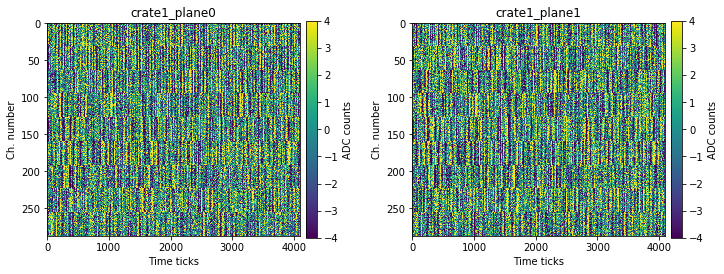

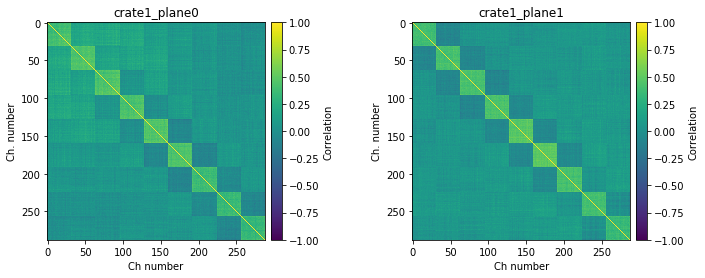

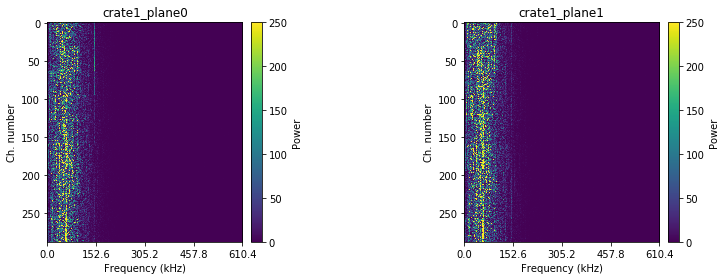

In [80]:
import scipy.signal as signal
from matplotlib.colors import LogNorm

crate_label='crate1'
crate = crates[crate_label]

# Just rearrange the waveform on two planes in groups of every 32 channels 
nchannels_minicrate = 576
nboard = 64
ncables = 32
groups = np.arange(int(nchannels_minicrate/ncables))
plane={
    '0' : np.concatenate([ crate._waveforms[ncables*n:ncables*(n+1)] for n in groups[(groups%2==0)] ]), 
    '1' : np.concatenate([ crate._waveforms[ncables*n:ncables*(n+1)] for n in groups[~(groups%2==0)] ])
}

corr= np.corrcoef(crate._waveforms)
corrd = { key : np.corrcoef(item) for key, item in plane.items() }

def getPowerVec(waveforms,maxFrequency):
    meanValue = np.mean(waveforms,axis=-1)
    
    newShape = (meanValue.shape)+(1,)
    
    if meanValue.ndim > 0:
        meanValue = meanValue.reshape((meanValue.shape)+(1,))
    
    corWave = waveforms - meanValue
    
    # Use scipy to compute the power spectrum directly
    freqVec, powerVec = signal.periodogram(corWave,maxFrequency) #,axis=-1)
    
    return freqVec,powerVec

fftd = { key : getPowerVec(item, 1.25)[1] for key, item in plane.items() }


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,2, figsize=(12,4) )

for idx, plane_label in enumerate(['0', '1']):
    
    ax[idx].set_title(crate_label+"_plane"+plane_label)
    out =ax[idx].imshow(plane[plane_label], vmin=-4, vmax=4, aspect = 12)
    ax[idx].set_xlabel('Time ticks')
    ax[idx].set_ylabel('Ch. number')
    
    fig.colorbar(out, ax=ax[idx], label='ADC counts', pad=0.02)


#///////////////////////////////////////////////////////////////

fig, ax = plt.subplots(1,2, figsize=(12,4) )

for idx, plane_label in enumerate(['0', '1']):
    
    ax[idx].set_title(crate_label+"_plane"+plane_label)
    out =ax[idx].imshow(corrd[plane_label], vmin=-1, vmax=1, )
    ax[idx].set_xlabel('Ch number')
    ax[idx].set_ylabel('Ch. number')
    
    fig.colorbar(out, ax=ax[idx], label='Correlation', pad=0.02)

#///////////////////////////////////////////////////////////////

fig, ax = plt.subplots(1,2, figsize=(12,4) )

for idx, plane_label in enumerate(['0', '1']):
    
    ax[idx].set_title(crate_label+"_plane"+plane_label)
    out =ax[idx].imshow(fftd[plane_label], aspect=8, vmin=0.0, vmax=250)
    ax[idx].set_xlabel('Frequency (kHz)')
    ax[idx].set_ylabel('Ch. number')
    
    labels = [ '%.1f' % label for label in np.linspace(0.0, 1250, fftd[plane_label].shape[1]) ]
    
    #print([tick for tick in ax[idx].get_xticks()[1:-1]])
    #ax[idx].set_xticklabels( [ labels[int(tick)] for tick in ax[idx].get_xticks()[1:-1] ] )

    fig.colorbar(out, ax=ax[idx], label='Power', pad=0.02)
 
#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(fftd['0'], aspect=5, vmin=0.0, vmax=250)
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(fftd['1'], aspect=5, vmin=0.0, vmax=250)
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(figsize=(6,4) )
#ax.plot(np.linspace(0.0, fftd['0'].shape[1], fftd['0'].shape[1] ), np.mean(fftd['0'], axis=0), label='Plane 0' ) 
#ax.plot(np.linspace(0.0, fftd['1'].shape[1], fftd['1'].shape[1] ), np.mean(fftd['1'], axis=0), label='Plane 1' ) 
#ax.plot(np.linspace(0.0, fftd['1'].shape[1], fftd['1'].shape[1] ), np.mean(fftd['0'], axis=0)-np.mean(fftd['1'], axis=0), label='Plane0-Plane1' ) 

#ax.set_yscale('Log')
#ax.set_xlim((0, 600))
#ax.set_ylim((-200, 300))
#ax.legend()

plt.tight_layout()
plt.show()


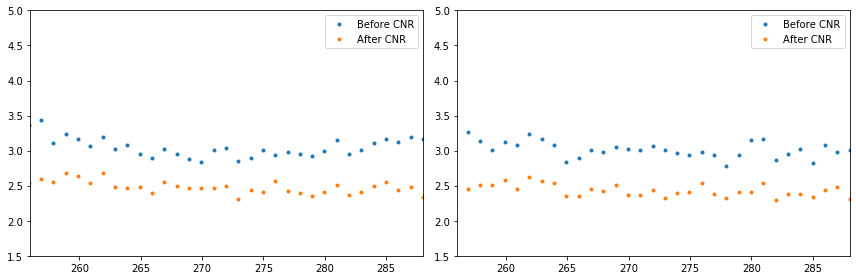

In [100]:
# Now I remove the cohterent noise using the median 

def getMedianNoiseCorrection(waveforms):
    median           = np.median(waveforms,axis=0)
    waveLessCoherent = waveforms - median.transpose()
    return waveLessCoherent

def removeCoherentNoise(waveforms,grouping):
    # Define placeholders for the output arrays
    waveLessCoherent = np.array([0])
    
    nChannels = waveforms.shape[0]
    
    for idx in range(0,nChannels,grouping):
        temp = getMedianNoiseCorrection(waveforms[idx:idx+grouping,:])
        if idx == 0:
            waveLessCoherent = temp
        else:
            waveLessCoherent = np.concatenate((waveLessCoherent,temp),axis=0)
        
    return waveLessCoherent

plane_cnr = { key : removeCoherentNoise(item, 32) for key, item in plane.items() }
corrd_cnr = { key : np.corrcoef(item) for key, item in plane_cnr.items() }
fftd_cnr = { key : getPowerVec(item, 1.25)[1] for key, item in plane_cnr.items() }

def _getRMS( waveform):
        rms = np.sqrt(np.mean(waveform**2,axis=1))
        return rms

rmsd = { key : _getRMS(item) for key, item in plane.items() }
rmsd_cnr = { key : _getRMS(item) for key, item in plane_cnr.items() }

fig, ax = plt.subplots(1,2, figsize=(12,4) )

for idx, plane_label in enumerate(['0', '1']):

    #ax[idx].set_title(label+"_plane"+plane_label+"_event"+str(event))
    ax[idx].plot(np.linspace(0.0, 576/2, 576/2 ), rmsd[plane_label], '.', label='Before CNR' )
    ax[idx].plot(np.linspace(0.0, 576/2, 576/2 ), rmsd_cnr[plane_label], '.', label='After CNR' )
    #ax[0].set_yscale('Log')
    #ax[idx].set_xlim((0, 576/2))
    ax[idx].set_xlim((256, 288))
    ax[idx].set_ylim((1.5, 5.))
    ax[idx].legend()


#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(plane_cnr['0'], vmin=-6, vmax=6, aspect = 10)
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(plane_cnr['1'], vmin=-6, vmax=6, aspect = 10)
#fig.colorbar(out, ax=ax)

#///////////////////////////////////////////////////////////////

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(corrd_cnr['0'], vmin=-0.05, vmax=0.05)
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(corrd_cnr['1'], vmin=-0.05, vmax=0.05)
#fig.colorbar(out, ax=ax)

#///////////////////////////////////////////////////////////////

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(fftd_cnr['0'], aspect=5, norm=LogNorm(vmin=0.01, vmax=1000))
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(figsize=(12,4) )
#out =ax.imshow(fftd_cnr['1'], aspect=5, norm=LogNorm(vmin=0.01, vmax=1000))
#fig.colorbar(out, ax=ax)

#fig, ax = plt.subplots(1,2, figsize=(12,4) )

#ax[0].plot(np.linspace(0.0, 1.25, fftd['0'].shape[1] ), np.mean(fftd['0'], axis=0), label='Noise' ) 
#ax[0].plot(np.linspace(0.0, 1.25, fftd_cnr['0'].shape[1] ), np.mean(fftd_cnr['0'], axis=0), label='Denoised' ) 
#ax[0].plot(np.linspace(0.0, 1.25, fftd_cnr['0'].shape[1] ), np.mean(fftd['0'], axis=0) - np.mean(fftd_cnr['0'], axis=0)  , label='Difference' )
#ax[0].set_yscale('Log')
#ax[0].set_xlim((0.0, 0.4))
#ax[0].set_ylim((0.1, 250))
#ax[0].legend()

#ax[1].plot(np.linspace(0.0, 1.25, fftd['1'].shape[1] ), np.mean(fftd['1'], axis=0), label='Noise' ) 
#ax[1].plot(np.linspace(0.0, 1.25, fftd_cnr['1'].shape[1] ), np.mean(fftd_cnr['1'], axis=0), label='Denoised' ) 
#ax[1].plot(np.linspace(0.0, 1.25, fftd_cnr['1'].shape[1] ), np.mean(fftd['1'], axis=0)-np.mean(fftd_cnr['1'], axis=0), label='Difference' )
#ax[1].set_yscale('Log')
#ax[1].set_xlim((0.0, 0.4))
#ax[1].set_ylim((0.1, 250))
#ax[1].legend()

plt.tight_layout()
plt.show()



(0.0, 1.05)

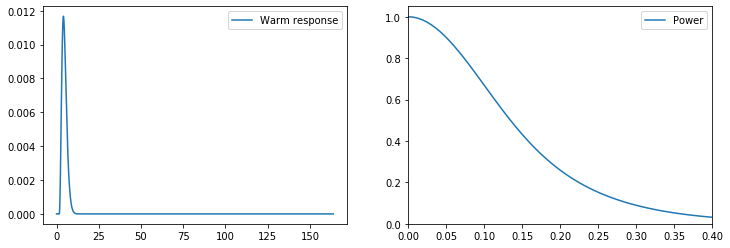

In [6]:
from sigproc_tools.sigproc_objects.electronicsresponse import ElectronicsResponse

nticks = 4096
sampling_time=0.04 #25 MHz
sampling_freq=1./sampling_time

from scipy.stats import norm

#ticks = np.linspace(0, nticks*sampling_time, nticks)
#arg = norm.pdf(ticks, 0, 1)
eresp = ElectronicsResponse(nticks, sampling_time)
ticks = eresp.timeBins
arg = eresp.electronicsResponse
fft = np.fft.fft(arg) 
freqs = np.linspace(0.0, sampling_freq, len(fft))

fig, ax = plt.subplots(1,2, figsize=(12,4) )

ax[0].plot(ticks, arg, label='Warm response' ) 
ax[0].legend()
#ax[1].plot(freqs[0:100], fft.real[0:100], label='Real' )
#ax[1].plot(freqs[0:100], fft.imag[0:100], label='Imag' ) 
ax[1].plot(freqs[0:100], np.abs(fft)[0:100], label='Power' ) 
ax[1].legend()
ax[1].set_xlim((0., 0.4))
ax[1].set_ylim((0.0, 1.05))
#ax[1].set_yscale('Log')
